# Calculate and generate R2 score figures to assess model performance across stains

## Import libraries

In [1]:
import pathlib

import joblib
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

## Set paths

In [2]:
# Output for figures
figures_dir = pathlib.Path("./figures").resolve()
figures_dir.mkdir(parents=True, exist_ok=True)

## Define features per stain to use for filtering columns

In [3]:
# Define the path to the YAML file with all the features per stain
yaml_file_path = pathlib.Path("./features_dict.yml").resolve()

# Load the column names dictionary from the YAML file
with open(yaml_file_path, 'r') as yaml_file:
    features_dict = yaml.safe_load(yaml_file)

# Access the lists of normalized features per stain
nucleus_features = features_dict['nucleus_features']
a647_features = features_dict['a647_features']
gold_features = features_dict['gold_features']

# Now you can use these lists for further operations
print(f"Nucleus Features: {len(nucleus_features)}")
print(f"A647 Features: {len(a647_features)}")
print(f"Gold Features: {len(gold_features)}")


Nucleus Features: 225
A647 Features: 170
Gold Features: 170


## Load in data splits

In [4]:
model_dir = pathlib.Path('./models')  # Path to the folder with models

# paths to the data splits
training_data_path = pathlib.Path('./data/training_data.parquet')
testing_data_path = pathlib.Path('./data/testing_data.parquet')
holdout_data_path = pathlib.Path('./data/holdout_data_293T.parquet')

# Load your datasets
training_df = pd.read_parquet(training_data_path)
testing_df = pd.read_parquet(testing_data_path)
holdout_df = pd.read_parquet(holdout_data_path)

## Generate list of the all feature models

In [5]:
# List all model files in 'final' and 'shuffled_baseline' folders
all_feature_models = [
    file for file in model_dir.rglob('*_tuned_model.joblib')
    if file.parent.name in ['all_features']
]

# Print the number of model files found
print(len(all_feature_models))

4


In [6]:
# Create an empty list to store the results
all_features_results = []

# Assuming all_feature_models is defined and contains your model files
for model_file in all_feature_models:
    # Determine the model type based on whether the filename contains "shuffled"
    if "shuffled" in model_file.stem:
        model_type = 'shuffled'
    else:
        model_type = 'final'

    # Initialize variables to check for stain
    stain = None
    model_name = None
    
    # Check if the model name contains 'A647' or 'GOLD' to set the appropriate features
    if 'A647' in model_file.stem:
        stain = 'A647'
    elif 'GOLD' in model_file.stem:
        stain = 'GOLD'
    else:
        # Skip if the model name doesn't match any feature group
        print(f"Skipping {model_file.stem} as it does not match any feature group.")
        continue

    # Set the stain features based on the identified stain
    stain_features = a647_features if stain == 'A647' else gold_features

    # Load the model
    model = joblib.load(model_file)

    # X will contain nucleus features for all splits
    X_train = training_df[nucleus_features]
    X_test = testing_df[nucleus_features]
    X_holdout = holdout_df[nucleus_features]

    # y will be the features matching the stain
    y_train = training_df[stain_features]
    y_test = testing_df[stain_features]
    y_holdout = holdout_df[stain_features]

    # Predict on training, testing, and holdout data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_holdout_pred = model.predict(X_holdout)

    # Calculate R2 scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    r2_holdout = r2_score(y_holdout, y_holdout_pred)

    # Append results to the list, including 'Model type'
    all_features_results.append({'Stain': stain, 'Data split': 'Training', 'R2 score': r2_train, 'Model type': model_type})
    all_features_results.append({'Stain': stain, 'Data split': 'Testing', 'R2 score': r2_test, 'Model type': model_type})
    all_features_results.append({'Stain': stain, 'Data split': 'Holdout', 'R2 score': r2_holdout, 'Model type': model_type})

# Convert the results into a dataframe
all_features_results_df = pd.DataFrame(all_features_results)

print(all_features_results_df.shape)
all_features_results_df

(12, 4)


,Stain,Data split,R2 score,Model type
0,GOLD,Training,0.011765,shuffled
1,GOLD,Testing,0.011678,shuffled
2,GOLD,Holdout,-16.262110,shuffled
3,GOLD,Training,0.301145,final
4,GOLD,Testing,0.303534,final
5,GOLD,Holdout,-3.078732,final
6,A647,Training,0.011765,shuffled
7,A647,Testing,0.011674,shuffled
8,A647,Holdout,-6.963805,shuffled
9,A647,Training,0.256342,final


## Plot R2 score results across stains

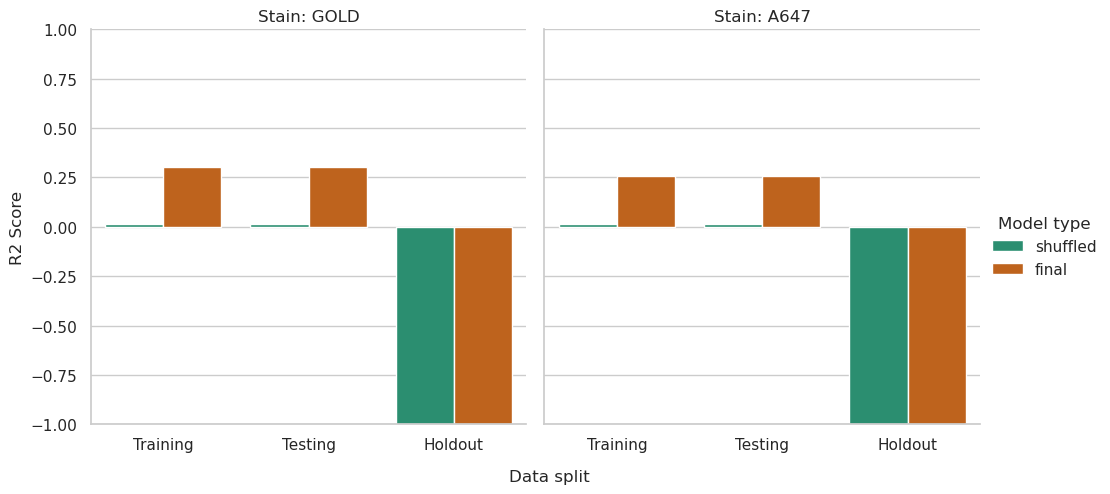

In [7]:
# Cap R2 scores below -1 at -1
all_features_results_df['R2 score'] = all_features_results_df['R2 score'].apply(lambda x: max(x, -1))

# Set the plot style
sns.set_theme(style="whitegrid")

# Create a faceted grouped bar plot based on 'Stain'
g = sns.catplot(
    data=all_features_results_df,
    x="Data split", 
    y="R2 score", 
    hue="Model type", 
    col="Stain",
    kind="bar",
    palette="Dark2",
    errorbar=None,  # Disable error bars
    height=5, 
    aspect=1
)

# Set y-axis limits from 1 to -1 for all facets
g.set(ylim=(-1, 1))

# Add titles and labels
g.set_titles("Stain: {col_name}")
g.set_axis_labels("", "R2 Score")  # Remove x-axis label from individual facets

# Add a single common x-axis label
g.figure.text(0.5, 0.02, "Data split", ha='center', fontsize=12)

# Save the figure
g.savefig(f"{figures_dir}/all_features_models_performance_r2.png", dpi=600)

# Show the plot
plt.show()


We can see that when using all of the features per stain together to predict from the nuclear stain features, we get a pretty low performance fpr both training and testing with very low performance when applied to the other cell line (holdout).

## Generate list with all individual models to access

In [8]:
# List all model files in 'final' and 'shuffled_baseline' folders
model_files = [
    file for file in model_dir.rglob('*_tuned_model.joblib')
    if file.parent.name in ['final', 'shuffled_baseline']
]

# Print the number of model files found
print(len(model_files))

680


## Generate and store R2 results for individual models across data splits

In [9]:
# Create an empty list to store the results
results = []

for model_file in model_files:
    # Get the parent folder (either 'final' or 'shuffled_baseline')
    folder_name = model_file.parent.name
    
    # Set the model type based on the folder name
    if folder_name == 'shuffled_baseline':
        model_name = model_file.stem.replace('_shuffled_tuned_model', '')
        model_type = 'shuffled'
    else:
        model_name = model_file.stem.replace('_tuned_model', '')
        model_type = 'final'

    # Check if the model name is in the A647 or GOLD features list
    if model_name in a647_features:
        stain = 'A647'
    elif model_name in gold_features:
        stain = 'GOLD'
    else:
        # Skip if the model name doesn't match any feature group
        print(f"Skipping {model_name} as it does not match any feature group.")
        continue

    # Load the model
    model = joblib.load(model_file)

    # X will contain nucleus features for all splits
    X_train = training_df[nucleus_features]
    X_test = testing_df[nucleus_features]
    X_holdout = holdout_df[nucleus_features]

    # y will be the column matching the model name
    y_train = training_df[model_name]
    y_test = testing_df[model_name]
    y_holdout = holdout_df[model_name]

    # Predict on training, testing, and holdout data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_holdout_pred = model.predict(X_holdout)

    # Calculate R2 scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    r2_holdout = r2_score(y_holdout, y_holdout_pred)

    # Append results to the list, including 'Model type'
    results.append({'Feature': model_name, 'Stain': stain, 'Data split': 'Training', 'R2 score': r2_train, 'Model type': model_type})
    results.append({'Feature': model_name, 'Stain': stain, 'Data split': 'Testing', 'R2 score': r2_test, 'Model type': model_type})
    results.append({'Feature': model_name, 'Stain': stain, 'Data split': 'Holdout', 'R2 score': r2_holdout, 'Model type': model_type})

# Convert the results into a dataframe
results_df = pd.DataFrame(results)

# Remove rows where 'Feature' starts with 'Nuclei_Location' (not an actual feature)
results_df = results_df[~results_df['Feature'].str.startswith('Nuclei_Location')]

print(results_df.shape)
results_df.head()

(1968, 5)


,Feature,Stain,Data split,R2 score,Model type
0,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,GOLD,Training,0.000000,shuffled
1,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,GOLD,Testing,-0.000318,shuffled
2,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,GOLD,Holdout,-30.212871,shuffled
3,Nuclei_Intensity_MeanIntensityEdge_GOLD,GOLD,Training,0.000000,shuffled
4,Nuclei_Intensity_MeanIntensityEdge_GOLD,GOLD,Testing,-0.000013,shuffled


## Generate box plot comparing testing data across models and splits

### Set function

In [10]:
# Function to create the plot for each stain
def boxplot_r2(results_df: pd.DataFrame, palette_dict: dict, datasplit: str) -> None:
    """Boxplot of R2 scores across stains

    Args:
        results_df (pd.DataFrame): dataframe with R2 results that can be specific to a datasplit
        palette_dict (dict): dictionary with the colors for each measurement
        datasplit (str): string of what the datasplit being plotted is for the title
    """
    # Set the figure size
    plt.figure(figsize=(14, 8))

    # Create the horizontal box plot (one per Model type and Stain combination)
    sns.boxplot(
        data=results_df,
        x='R2 score',
        y='model_stain',  # model_stain on y-axis for horizontal comparison
        dodge=True,  # Adjust box plots for multiple hues
        fliersize=0,  # Hide the default outliers as we add scatter later
        width=0.5  # Adjust the width to increase separation
    )

    # Add scatter plot of individual points within each box, colored by 'Measurement'
    sns.stripplot(
        data=results_df,
        x='R2 score',
        y='model_stain',  # Same axis for horizontal separation
        hue='Measurement',  # Color by 'Measurement'
        palette=palette_dict,  # Customize colors with your palette
        jitter=True,  # Jitter the points slightly for better visibility
        dodge=True,
        size=8,  # Size of the scatter points
        edgecolor='black',
        linewidth=1,
        alpha=0.8  # Transparency of the points
    )

    # Customize the plot
    plt.title(f'R2 Scores by Model Type and Stain: {datasplit} data')
    plt.xlabel('R2 Score')
    plt.ylabel('Model Stain')

    # Move legend outside of the plot
    plt.legend(title='Measurement', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Improve layout
    plt.tight_layout()

    # Save
    plt.savefig(f"{figures_dir}/shuffled_versus_final_r2.png", dpi=600)

    # Show plot
    plt.show()

### Filter only training data and format columns

In [11]:
# Only include rows where there is training data
filtered_results_df = results_df[results_df['Data split'] == 'Testing'].copy()

# Create the new 'model_stain' column
filtered_results_df['model_stain'] = filtered_results_df['Stain'] + ' (' + filtered_results_df['Model type'] + ')'

# Create a column to extract the first word from 'Feature'
filtered_results_df['Measurement'] = filtered_results_df['Feature'].apply(lambda x: x.split('_')[1])

print(filtered_results_df.shape)
filtered_results_df.head()

(656, 7)


,Feature,Stain,Data split,R2 score,Model type,model_stain,Measurement
1,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,GOLD,Testing,-0.000318,shuffled,GOLD (shuffled),RadialDistribution
4,Nuclei_Intensity_MeanIntensityEdge_GOLD,GOLD,Testing,-0.000013,shuffled,GOLD (shuffled),Intensity
7,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,GOLD,Testing,-0.000001,shuffled,GOLD (shuffled),RadialDistribution
10,Nuclei_Granularity_10_GOLD,GOLD,Testing,-0.000005,shuffled,GOLD (shuffled),Granularity
13,Nuclei_Texture_Contrast_GOLD_3_00_256,GOLD,Testing,-0.000178,shuffled,GOLD (shuffled),Texture


### Create color palette for measurements to use for all plots

In [12]:
#  Get unique Measurement values to create a consistent color palette
unique_measurements = filtered_results_df['Measurement'].unique()

# Create a fixed color palette based on the unique Measurement values
palette = sns.color_palette('Dark2', len(unique_measurements))
palette_dict = dict(zip(unique_measurements, palette))

### Plot R2 scores between shuffled and final models

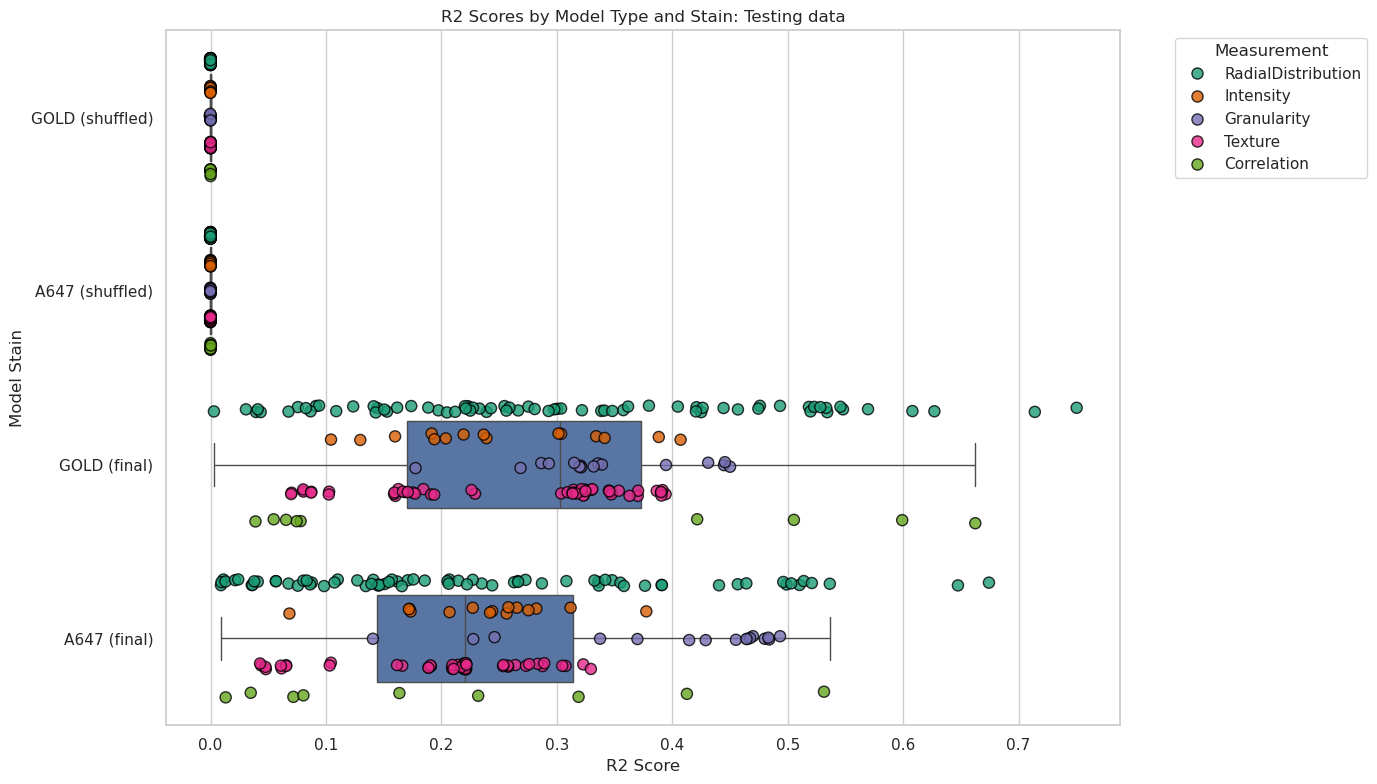

In [13]:
boxplot_r2(filtered_results_df, palette_dict, "Testing")

## Split features to get an R2 score per stain and plot R2 results

### Function to split features based on stain to have one R2 score per stain

In [14]:
def split_r2_score_features(df: pd.DataFrame, split_type: str, model_type: str) -> pd.DataFrame:
    """Remove stain from features to find the combinations of the same feature to have a column
    per stain R2 score and one row per feature.

    Args:
        df (pd.DataFrame): dataframe with R2 score results for each feature (with stain)
        split_type (str): string of the data split to include as column in output (e.g., Testing, Training, or Holdout)
        model_type (str): string of the model type to include as column in output (e.g., Final or Shuffled)

    Returns:
        pd.DataFrame: final dataframe with each row as a common feature with an R2 score per stain
    """
    # Create a copy of df_subset to avoid modifying the original slice
    df_subset = df.copy()
    
    # Step 1: Remove rows where 'Feature' contains both 'A647' and 'GOLD'
    df_subset = df_subset[~(df_subset['Feature'].str.contains('A647') & df_subset['Feature'].str.contains('GOLD'))]
    
    # Step 2: Add 'Feature_clean' without modifying 'Feature'
    df_subset['Feature_clean'] = df_subset['Feature'].str.replace('A647', '').str.replace('GOLD', '').str.strip('_')
    
    # Step 3: Find duplicates by 'Feature_clean' and keep R2 score for both 'A647' and 'GOLD'
    a647_scores = df_subset[df_subset['Stain'] == 'A647'][['Feature', 'Feature_clean', 'R2 score']].rename(columns={'Feature': 'Feature_A647', 'R2 score': 'A647 R2 score'})
    gold_scores = df_subset[df_subset['Stain'] == 'GOLD'][['Feature', 'Feature_clean', 'R2 score']].rename(columns={'Feature': 'Feature_GOLD', 'R2 score': 'GOLD R2 score'})
    
    # Step 4: Merge the dataframes based on 'Feature_clean'
    merged_results = pd.merge(a647_scores, gold_scores, on='Feature_clean', how='outer')
    
    # Step 5: Drop duplicates based on 'Feature_clean'
    merged_results = merged_results.drop_duplicates(subset='Feature_clean')
    
    # Add columns to indicate the data split and model type
    merged_results['Data split'] = split_type
    merged_results['Model type'] = model_type
    
    return merged_results

### Split out the data based on model type and data split to make it easier to process each feature without duplicates

In [15]:
# Split the dataframe into 'Training', 'Testing', and 'Holdout' for both 'final' and 'shuffled'
df_training_final = results_df[(results_df['Data split'] == 'Training') & (results_df['Model type'] == 'final')]
df_testing_final = results_df[(results_df['Data split'] == 'Testing') & (results_df['Model type'] == 'final')]
df_holdout_final = results_df[(results_df['Data split'] == 'Holdout') & (results_df['Model type'] == 'final')]

df_training_shuffled = results_df[(results_df['Data split'] == 'Training') & (results_df['Model type'] == 'shuffled')]
df_testing_shuffled = results_df[(results_df['Data split'] == 'Testing') & (results_df['Model type'] == 'shuffled')]
df_holdout_shuffled = results_df[(results_df['Data split'] == 'Holdout') & (results_df['Model type'] == 'shuffled')]

### Format the feature and R2 score columns and concat all data back together

In [16]:
# Process each subset with designation
training_final_results = split_r2_score_features(df_training_final, 'Training', 'final')
testing_final_results = split_r2_score_features(df_testing_final, 'Testing', 'final')
holdout_final_results = split_r2_score_features(df_holdout_final, 'Holdout', 'final')

training_shuffled_results = split_r2_score_features(df_training_shuffled, 'Training', 'shuffled')
testing_shuffled_results = split_r2_score_features(df_testing_shuffled, 'Testing', 'shuffled')
holdout_shuffled_results = split_r2_score_features(df_holdout_shuffled, 'Holdout', 'shuffled')

# Concatenate the results
final_results_df = pd.concat([training_final_results, testing_final_results, holdout_final_results, 
                              training_shuffled_results, testing_shuffled_results, holdout_shuffled_results])

# Extract 'Measurement' from 'Feature_clean' after merging
final_results_df['Measurement'] = final_results_df['Feature_clean'].str.split('_').str[1]

# Drop rows with any NaN values
final_results_df = final_results_df.dropna()

# Display the final dataframe
print(final_results_df.shape)
final_results_df.head(10)

(960, 8)


,Feature_A647,Feature_clean,A647 R2 score,Feature_GOLD,GOLD R2 score,Data split,Model type,Measurement
2,Nuclei_Correlation_Costes_DAPI_A647,Nuclei_Correlation_Costes_DAPI,0.085093,Nuclei_Correlation_Costes_DAPI_GOLD,0.050192,Training,final,Correlation
3,Nuclei_Correlation_Manders_DAPI_A647,Nuclei_Correlation_Manders_DAPI,0.069286,Nuclei_Correlation_Manders_DAPI_GOLD,0.068873,Training,final,Correlation
4,Nuclei_Correlation_Manders_A647_DAPI,Nuclei_Correlation_Manders__DAPI,0.542403,Nuclei_Correlation_Manders_GOLD_DAPI,0.636784,Training,final,Correlation
5,Nuclei_Correlation_RWC_DAPI_A647,Nuclei_Correlation_RWC_DAPI,0.218006,Nuclei_Correlation_RWC_DAPI_GOLD,0.510976,Training,final,Correlation
6,Nuclei_Correlation_RWC_A647_DAPI,Nuclei_Correlation_RWC__DAPI,0.305629,Nuclei_Correlation_RWC_GOLD_DAPI,0.600258,Training,final,Correlation
7,Nuclei_Granularity_1_A647,Nuclei_Granularity_1,0.223995,Nuclei_Granularity_1_GOLD,0.300726,Training,final,Granularity
8,Nuclei_Granularity_10_A647,Nuclei_Granularity_10,0.479313,Nuclei_Granularity_10_GOLD,0.316988,Training,final,Granularity
9,Nuclei_Granularity_11_A647,Nuclei_Granularity_11,0.480990,Nuclei_Granularity_11_GOLD,0.316532,Training,final,Granularity
10,Nuclei_Granularity_12_A647,Nuclei_Granularity_12,0.506167,Nuclei_Granularity_12_GOLD,0.328069,Training,final,Granularity
11,Nuclei_Granularity_13_A647,Nuclei_Granularity_13,0.485751,Nuclei_Granularity_13_GOLD,0.333874,Training,final,Granularity


### Create scatterplot comparing training and testing results

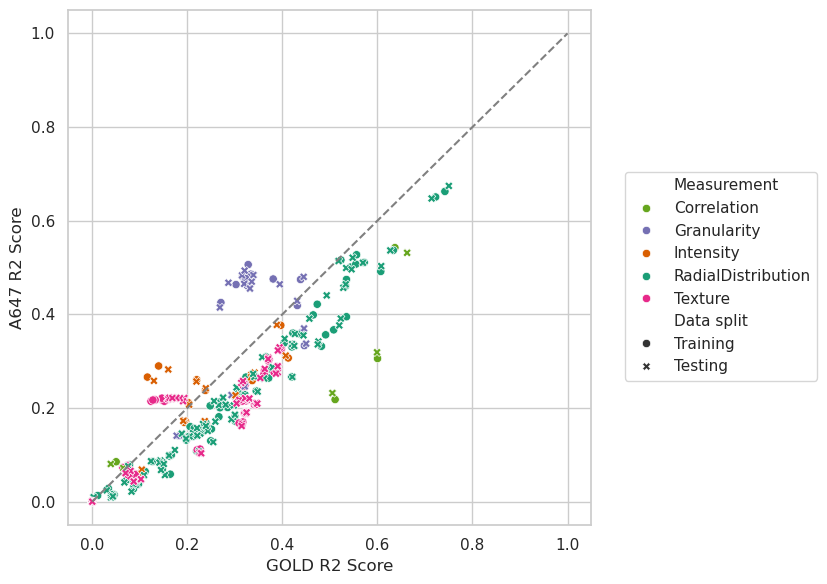

In [17]:
# Filter the dataframe for 'Training' and 'Testing' data splits only
filtered_final_results_df = final_results_df[final_results_df['Data split'].isin(['Training', 'Testing'])]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8.5, 6))

# Plot with different shapes based on 'Data split'
sns.scatterplot(data=filtered_final_results_df,
                x='GOLD R2 score', y='A647 R2 score', 
                hue='Measurement', style='Data split', 
                palette=palette_dict, ax=ax)

# Add y = x line as reference
lims = [0, 1]  # For R² scores, which range from 0 to 1
ax.plot(lims, lims, '--', color='gray')

# Set plot labels
ax.set_xlabel('GOLD R2 Score')
ax.set_ylabel('A647 R2 Score')

# Add legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')

# Adjust layout to make space for the legend
plt.tight_layout()

# Save
plt.savefig(f"{figures_dir}/training_versus_testing_scatter_r2.png", dpi=600)

# Show plot
plt.show()


### Create scatterplot comparing holdout and testing results

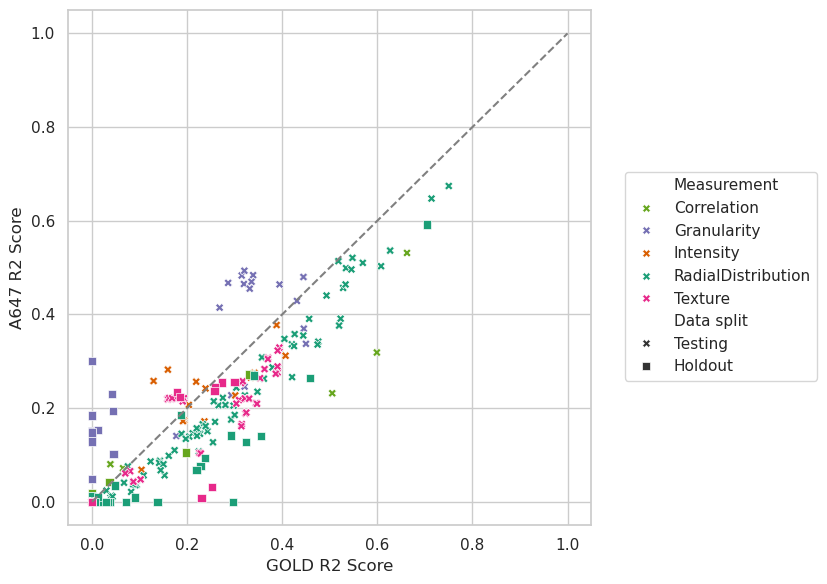

In [18]:
# Filter the dataframe for 'Holdout' and 'Testing' data splits only
filtered_final_results_df = final_results_df[final_results_df['Data split'].isin(['Holdout', 'Testing'])]

# Set any R² score below 0 to 0
filtered_final_results_df.loc[:, 'GOLD R2 score'] = filtered_final_results_df['GOLD R2 score'].clip(lower=0)
filtered_final_results_df.loc[:, 'A647 R2 score'] = filtered_final_results_df['A647 R2 score'].clip(lower=0)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8.5, 6))

# Custom markers for 'Testing' (X) and 'Holdout' (Square)
markers = {'Testing': 'X', 'Holdout': 's'}

# Plot with different shapes based on 'Data split'
sns.scatterplot(data=filtered_final_results_df,
                x='GOLD R2 score', y='A647 R2 score', 
                hue='Measurement', style='Data split', 
                markers=markers, palette=palette_dict, ax=ax)

# Add y = x line as reference
lims = [0, 1]  # For R² scores, which range from 0 to 1
ax.plot(lims, lims, '--', color='gray')

# Set plot labels
ax.set_xlabel('GOLD R2 Score')
ax.set_ylabel('A647 R2 Score')

# Add legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')

# Adjust layout to make space for the legend
plt.tight_layout()

# Save
plt.savefig(f"{figures_dir}/holdout_versus_testing_scatter_r2.png", dpi=600)

# Show plot
plt.show()

## Holdout data boxplot comparing between stains

### Filter only holdout data from the final model

Note: We know the shuffled models are under performing in the previous plot so we don't need to include it here.

In [19]:
# Only include rows where 'Data split' contains 'Holdout'
holdout_df = results_df[results_df['Data split'] == 'Holdout']

# Remove rows where 'Model type' starts with 'shuffled'
holdout_df = holdout_df[~holdout_df['Model type'].str.startswith('shuffled')]

print(holdout_df.shape)
holdout_df.sort_values(by='R2 score', ascending=False).head()

(328, 5)


,Feature,Stain,Data split,R2 score,Model type
1529,Nuclei_RadialDistribution_ZernikePhase_GOLD_2_2,GOLD,Holdout,0.704215,final
1475,Nuclei_RadialDistribution_ZernikePhase_A647_2_2,A647,Holdout,0.592030,final
1214,Nuclei_RadialDistribution_ZernikePhase_GOLD_4_4,GOLD,Holdout,0.458229,final
1892,Nuclei_RadialDistribution_ZernikePhase_GOLD_6_6,GOLD,Holdout,0.354877,final
1652,Nuclei_RadialDistribution_ZernikePhase_GOLD_1_1,GOLD,Holdout,0.341240,final


### Generate boxplot

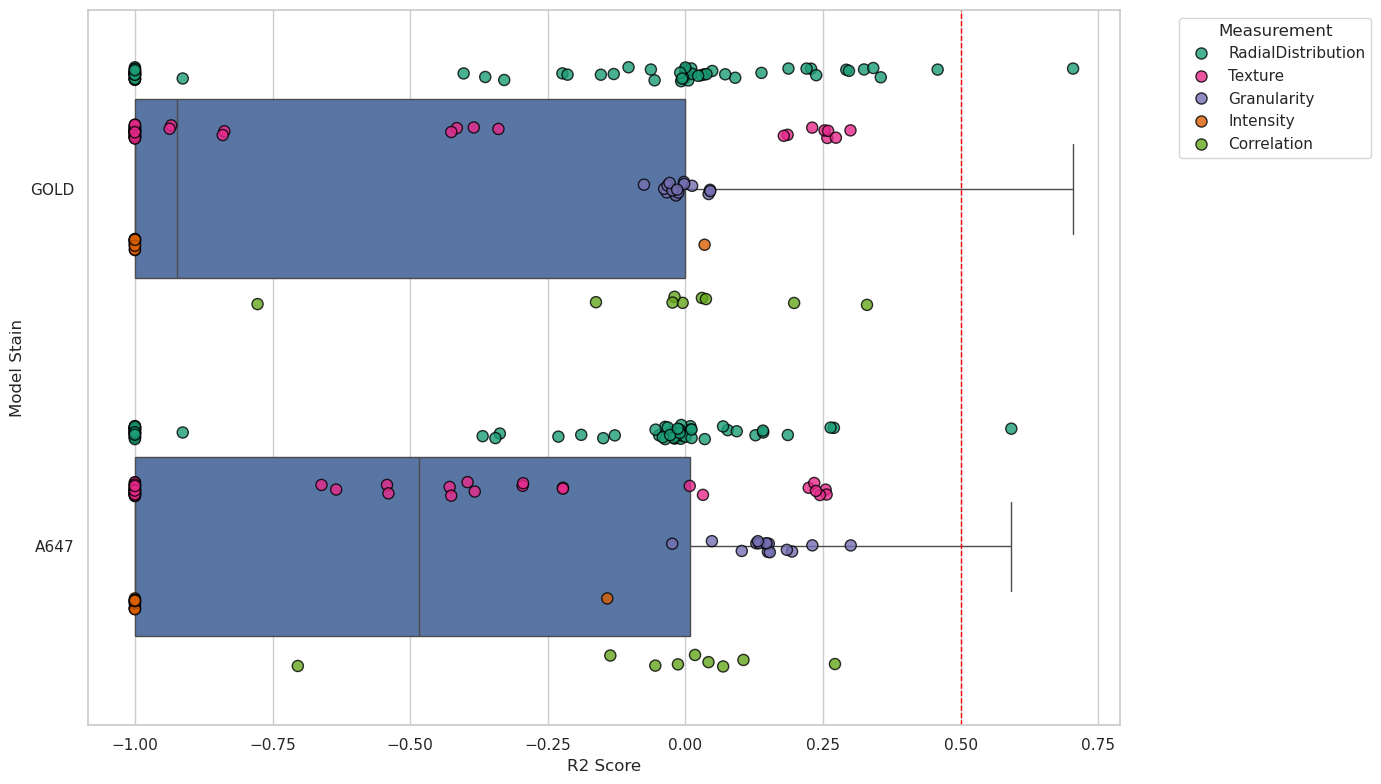

In [20]:
# Replace R2 scores less than -1 with -1
holdout_df.loc[holdout_df['R2 score'] < -1, 'R2 score'] = -1

# Create a column to extract the first word from 'Feature'
holdout_df['Measurement'] = holdout_df['Feature'].apply(lambda x: x.split('_')[1])

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the horizontal box plot (one per Model type and Stain combination)
sns.boxplot(
    data=holdout_df,
    x='R2 score',
    y='Stain',  
    dodge=True,  # Adjust box plots for multiple hues
    fliersize=0,  # Hide the default outliers as we add scatter later
    width=0.5  # Adjust the width to increase separation
)

# Add scatter plot of individual points within each box, colored by 'Measurement'
sns.stripplot(
    data=holdout_df,
    x='R2 score',
    y='Stain',  # Same axis for horizontal separation
    hue='Measurement',  # Color by 'Measurement'
    palette=palette_dict,  # Customize colors with your palette
    jitter=True,  # Jitter the points slightly for better visibility
    dodge=True,
    size=8,  # Size of the scatter points
    edgecolor='black',
    linewidth=1,
    alpha=0.8  # Transparency of the points
)

# Add a vertical dashed line at R2 score = 0.5
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

# Customize the plot
plt.xlabel('R2 Score')
plt.ylabel('Model Stain')

# Move legend outside of the plot
plt.legend(title='Measurement', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout
plt.tight_layout()

# Save
plt.savefig(f"{figures_dir}/holdout_a647_versus_gold_r2.png", dpi=600)

# Show plot
plt.show()

## Generate boxplot figure comparing the top 2 model feature distributions across stains using the training data

Note: We do not save these figures as the results from them do not tell a clear story to use elsewhere.

### Identify top two features per stain

These will be the same two RadialDistribution features (FracatD and Zernike 2,2).

In [21]:
# Filter the dataframe to include only rows where Data split is 'Testing'
testing_results_df = final_results_df[final_results_df['Data split'] == 'Testing']

# Sort the filtered dataframe by A647 R2 score in descending order
sorted_a647_df = testing_results_df[
    ~testing_results_df['A647 R2 score'].isna()
].sort_values(by='A647 R2 score', ascending=False)

# Display the top rows based on A647 R2 score
sorted_a647_df.head(10)  # Show the top 10 rows


,Feature_A647,Feature_clean,A647 R2 score,Feature_GOLD,GOLD R2 score,Data split,Model type,Measurement
83,Nuclei_RadialDistribution_ZernikePhase_A647_2_2,Nuclei_RadialDistribution_ZernikePhase__2_2,0.674295,Nuclei_RadialDistribution_ZernikePhase_GOLD_2_2,0.750269,Testing,final,RadialDistribution
41,Nuclei_RadialDistribution_FracAtD_A647_4of4,Nuclei_RadialDistribution_FracAtD__4of4,0.647445,Nuclei_RadialDistribution_FracAtD_GOLD_4of4,0.714032,Testing,final,RadialDistribution
39,Nuclei_RadialDistribution_FracAtD_A647_2of4,Nuclei_RadialDistribution_FracAtD__2of4,0.536433,Nuclei_RadialDistribution_FracAtD_GOLD_2of4,0.627031,Testing,final,RadialDistribution
4,Nuclei_Correlation_Manders_A647_DAPI,Nuclei_Correlation_Manders__DAPI,0.531400,Nuclei_Correlation_Manders_GOLD_DAPI,0.662475,Testing,final,Correlation
58,Nuclei_RadialDistribution_ZernikeMagnitude_A64...,Nuclei_RadialDistribution_ZernikeMagnitude__4_4,0.520850,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,0.547864,Testing,final,RadialDistribution
53,Nuclei_RadialDistribution_ZernikeMagnitude_A64...,Nuclei_RadialDistribution_ZernikeMagnitude__2_2,0.513854,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,0.518320,Testing,final,RadialDistribution
57,Nuclei_RadialDistribution_ZernikeMagnitude_A64...,Nuclei_RadialDistribution_ZernikeMagnitude__4_2,0.510199,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,0.569539,Testing,final,RadialDistribution
88,Nuclei_RadialDistribution_ZernikePhase_A647_4_4,Nuclei_RadialDistribution_ZernikePhase__4_4,0.503028,Nuclei_RadialDistribution_ZernikePhase_GOLD_4_4,0.607991,Testing,final,RadialDistribution
45,Nuclei_RadialDistribution_MeanFrac_A647_4of4,Nuclei_RadialDistribution_MeanFrac__4of4,0.498890,Nuclei_RadialDistribution_MeanFrac_GOLD_4of4,0.534182,Testing,final,RadialDistribution
65,Nuclei_RadialDistribution_ZernikeMagnitude_A64...,Nuclei_RadialDistribution_ZernikeMagnitude__6_6,0.496135,Nuclei_RadialDistribution_ZernikeMagnitude_GOL...,0.545637,Testing,final,RadialDistribution


In [22]:
# Create a list to store top features
top_features_list = []

# Filter the dataframe to include only rows where Data split is 'Testing'
testing_features_df = final_results_df[final_results_df['Data split'] == 'Testing']

# Iterate over each stain
for stain in ['A647', 'GOLD']:
    # Filter features for the current stain and sort by R2 score
    stain_features_df = testing_features_df[
        ~testing_features_df[f'{stain} R2 score'].isna()
    ].sort_values(by=f'{stain} R2 score', ascending=False)
    
    # Get the top 4 features for each stain
    top_stain_features = stain_features_df.head(2)[f'Feature_{stain}'].tolist()
    
    # Add to the top features list
    top_features_list.extend(top_stain_features)

# Print the top features list
print(len(top_features_list))
print(top_features_list)


4
['Nuclei_RadialDistribution_ZernikePhase_A647_2_2', 'Nuclei_RadialDistribution_FracAtD_A647_4of4', 'Nuclei_RadialDistribution_ZernikePhase_GOLD_2_2', 'Nuclei_RadialDistribution_FracAtD_GOLD_4of4']


### Filter training data to only include metadata and top feature columns

In [23]:
# Get all columns with the 'Metadata' prefix
metadata_columns = [col for col in training_df.columns if col.startswith('Metadata')]

# Combine the lists of top features and metadata columns
selected_columns = metadata_columns + top_features_list

# Filter the training_df dataframe to include only the selected columns
filtered_training_df = training_df[selected_columns]

print(filtered_training_df.shape)
filtered_training_df.head()

(43406, 13)


,Metadata_CellLine,Metadata_Condition,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Nuclei_Site_Count,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Nuclei_RadialDistribution_ZernikePhase_A647_2_2,Nuclei_RadialDistribution_FracAtD_A647_4of4,Nuclei_RadialDistribution_ZernikePhase_GOLD_2_2,Nuclei_RadialDistribution_FracAtD_GOLD_4of4
0,786O,TMEM259 kd5,214,slide2,B3,M35,119,194.287533,47.829652,1.671669,-0.405430,1.518852,-0.432626
1,786O,FIBP kd7,125,slide1,A4,M36,106,1739.206684,1157.896218,-1.131722,-0.766128,-1.066300,-1.213491
2,786O,SART1 kd4,226,slide3,B2,M15,70,437.178872,1632.926118,-0.317490,1.952312,-0.277478,1.855720
3,786O,FIBP kd6,282,slide3,B3,M13,223,1916.067522,2103.329507,-0.611309,-0.994735,-0.547840,-1.190189
4,786O,SART1 kd4,205,slide1,B2,M37,31,1478.593750,2230.404891,-0.198209,0.627964,-0.220650,1.096577


### Plot distributions across features per feature

/tmp/ipykernel_1096071/4102547036.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


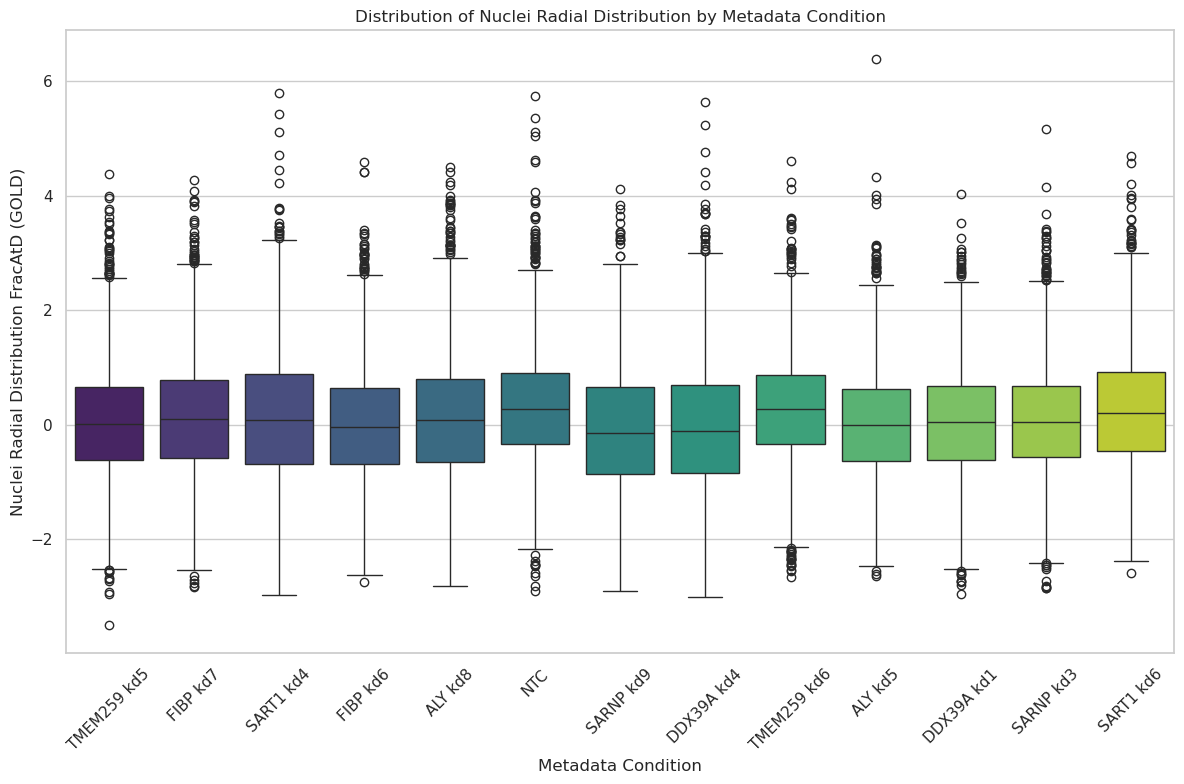

In [24]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create the vertical box plot
sns.boxplot(
    data=filtered_training_df,
    x='Metadata_Condition',  # Metadata_condition on x-axis
    y='Nuclei_RadialDistribution_FracAtD_GOLD_4of4',  # Nuclei_RadialDistribution_FracAtD_GOLD_4of4 on y-axis
    palette='viridis'  # You can choose a different palette if needed
)

# Customize the plot
plt.title('Distribution of Nuclei Radial Distribution by Metadata Condition')
plt.xlabel('Metadata Condition')
plt.ylabel('Nuclei Radial Distribution FracAtD (GOLD)')

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


/tmp/ipykernel_1096071/1679982373.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


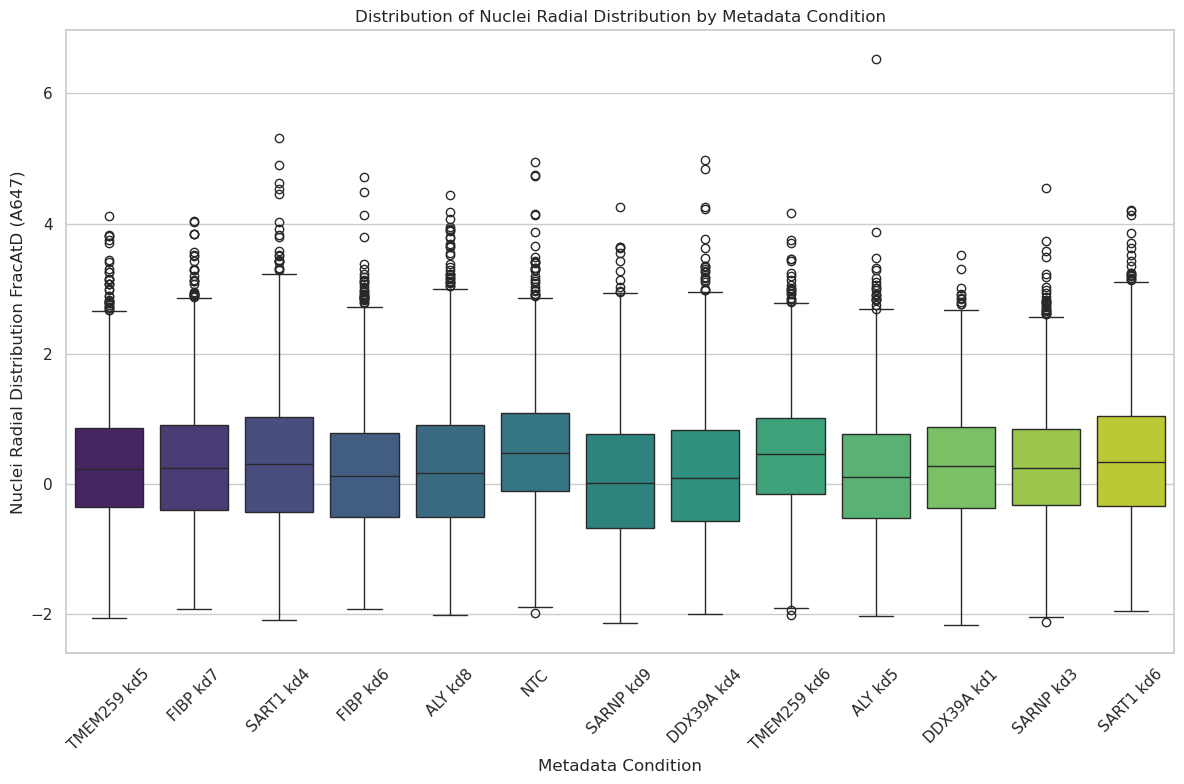

In [25]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create the vertical box plot
sns.boxplot(
    data=filtered_training_df,
    x='Metadata_Condition',  # Metadata_condition on x-axis
    y='Nuclei_RadialDistribution_FracAtD_A647_4of4',  
    palette='viridis'  # You can choose a different palette if needed
)

# Customize the plot
plt.title('Distribution of Nuclei Radial Distribution by Metadata Condition')
plt.xlabel('Metadata Condition')
plt.ylabel('Nuclei Radial Distribution FracAtD (A647)')

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


/tmp/ipykernel_1096071/1078374565.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


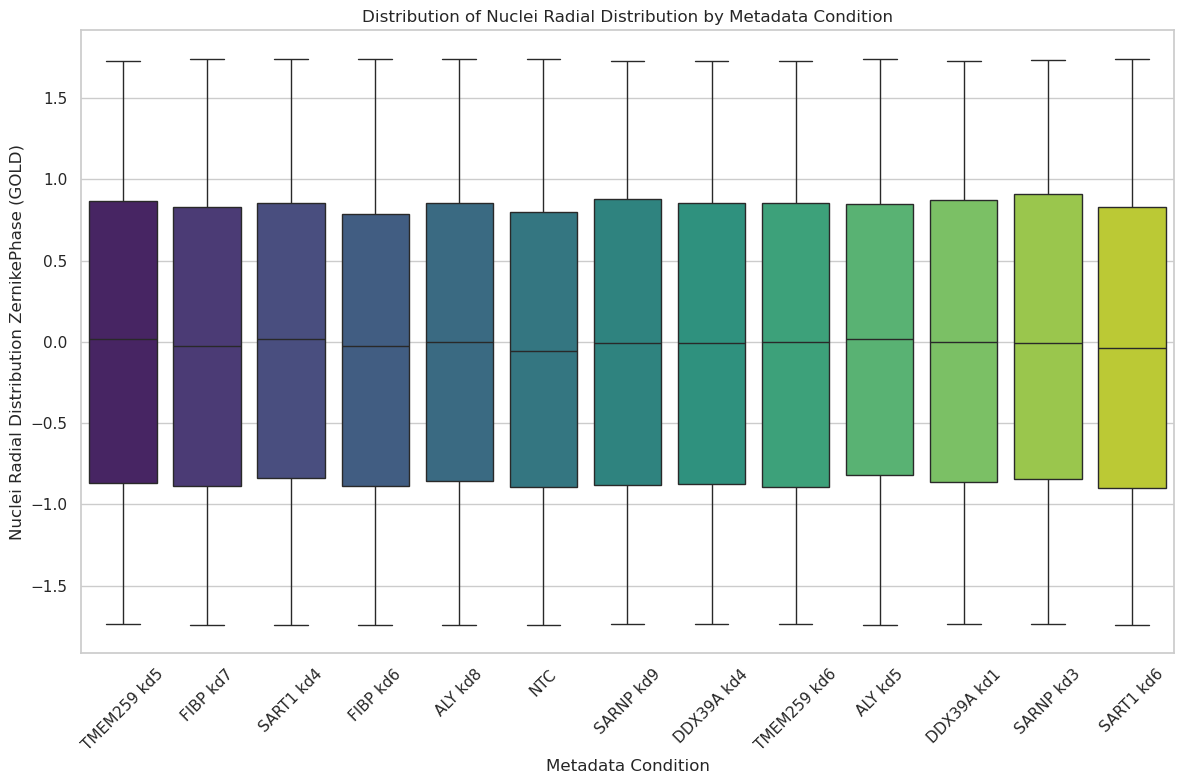

In [26]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create the vertical box plot
sns.boxplot(
    data=filtered_training_df,
    x='Metadata_Condition',  # Metadata_condition on x-axis
    y='Nuclei_RadialDistribution_ZernikePhase_GOLD_2_2',  
    palette='viridis'  # You can choose a different palette if needed
)

# Customize the plot
plt.title('Distribution of Nuclei Radial Distribution by Metadata Condition')
plt.xlabel('Metadata Condition')
plt.ylabel('Nuclei Radial Distribution ZernikePhase (GOLD)')

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()

/tmp/ipykernel_1096071/4275210155.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


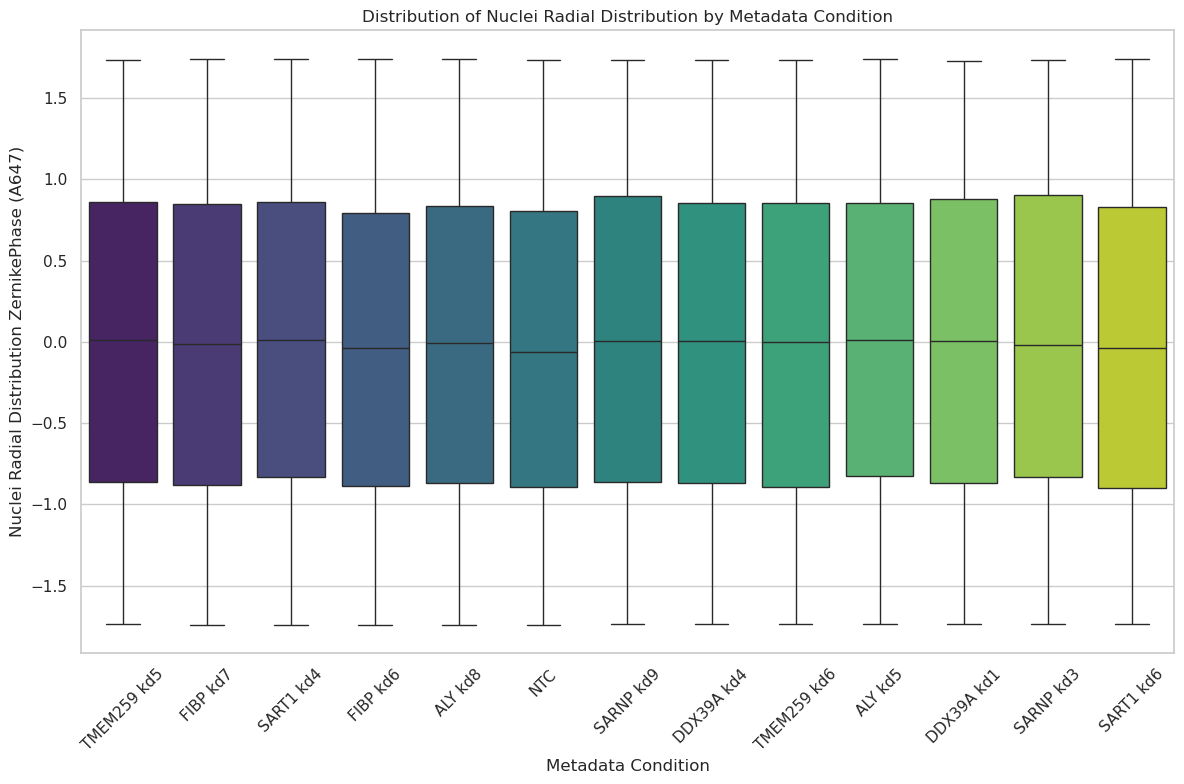

In [27]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create the vertical box plot
sns.boxplot(
    data=filtered_training_df,
    x='Metadata_Condition',  # Metadata_condition on x-axis
    y='Nuclei_RadialDistribution_ZernikePhase_A647_2_2',  
    palette='viridis'  # You can choose a different palette if needed
)

# Customize the plot
plt.title('Distribution of Nuclei Radial Distribution by Metadata Condition')
plt.xlabel('Metadata Condition')
plt.ylabel('Nuclei Radial Distribution ZernikePhase (A647)')

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()